# Preparations #

In [4]:
import warnings
warnings.simplefilter('ignore')

import numpy as np
import matplotlib.pyplot as plt
import skillsnetwork
print(f"skillsnetwork version: {skillsnetwork.__version__}")
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
print(f"tensorflow version: {tf.__version__}")

from tensorflow.keras import (
    layers,
    models,
)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Input,
    Conv2DTranspose,
    BatchNormalization,
    ReLU,
    Conv2D,
    LeakyReLU,
)
import time
import keras

from IPython import display

import os
from os import listdir
from pathlib import Path
import imghdr
from tqdm import tqdm

skillsnetwork version: 0.21.9
tensorflow version: 2.16.1


This part defines the save paths and the display functions.

(Generated pictures will be stored in a batch of ten in `.png` form)

In [ ]:
save_dir = '/kaggle/working/generated_images'
os.makedirs(save_dir, exist_ok=True)

def plot_array(X,title="",save_to=None):

    plt.rcParams['figure.figsize'] = (20,20)

    for i,x in enumerate(X[0:10]):
        x=x.numpy()
        max_=x.max()
        min_=x.min()
        xnew=np.uint(255*(x-min_)/(max_-min_))
        plt.subplot(1,10,i+1)
        plt.imshow(xnew)
        plt.axis("off")
        
    plt.show()    
    if save_to:
        plt.savefig(save_to) # the generated images will be saved as a batch of ten images in a png image
        print(f"\nSaved to {save_to}")   

# Loading and processing data #

In [57]:
img_height, img_width, batch_size=64,64,128 # set image size to (64,64)

# train data set
train_ds = tf.keras.utils.image_dataset_from_directory(
    '/kaggle/input/anime6308/faces',
    image_size=(img_height, img_width),                                                      
    batch_size=batch_size,                                                       
    label_mode=None)
                                                       

Found 70171 files.


___Normalization___

Apply the Lambda function on `train_ds` to normalize the pixel values of all the input images from $[0, 255]$ to $[-1, 1]$:


In [58]:
normalization_layer = tf.keras.layers.Rescaling(scale=1./127.5, offset=-1)
normalized_ds = train_ds.map(lambda x: normalization_layer(x))

___Display___

This part displays with an example batch, to show the generating format in the following training process.

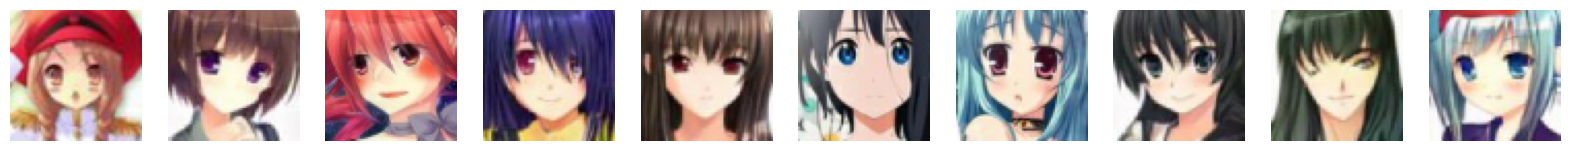

In [59]:
images=train_ds.take(1) # takes an example batch

X=[x for x in images] # convert to indexes

plot_array(X[0])

# Generator #

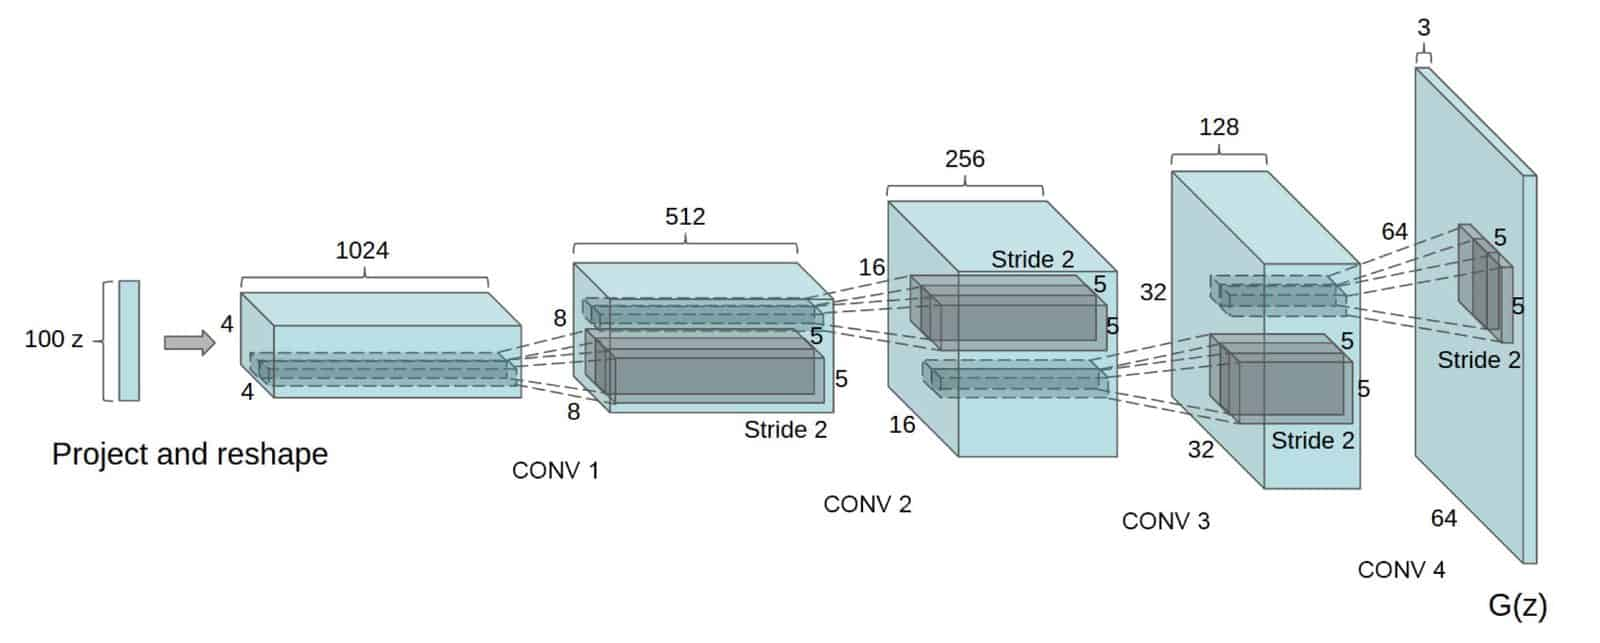
In the first four blocks, it contains three parts: *Convolution 2D Transpose Layer*, followed by a *Batch Normalization layer* and a **Relu activation**, while in the last block, the final layer is changed to be **Tanh activation**.


In [60]:
def make_generator():

    model=Sequential()

    # input is latent vector of 100 dimensions
    model.add(Input(shape=(1, 1, 100), name='input_layer'))

    # Block 1 dimensionality of the output space  64 * 8
    model.add(Conv2DTranspose(64 * 8, kernel_size=4, strides= 4, padding='same', kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02), use_bias=False, name='conv_transpose_1'))
    model.add(BatchNormalization(momentum=0.1,  epsilon=0.8, center=1.0, scale=0.02, name='bn_1'))
    model.add(ReLU(name='relu_1'))

    # Block 2: input is 4 x 4 x (64 * 8)
    model.add(Conv2DTranspose(64 * 4, kernel_size=4, strides= 2, padding='same', kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02), use_bias=False, name='conv_transpose_2'))
    model.add(BatchNormalization(momentum=0.1,  epsilon=0.8, center=1.0, scale=0.02, name='bn_2'))
    model.add(ReLU(name='relu_2'))

    # Block 3: input is 8 x 8 x (64 * 4)
    model.add(Conv2DTranspose(64 * 2, kernel_size=4,strides=  2, padding='same', kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02), use_bias=False, name='conv_transpose_3'))
    model.add(BatchNormalization(momentum=0.1,  epsilon=0.8,  center=1.0, scale=0.02, name='bn_3'))
    model.add(ReLU(name='relu_3'))


    # Block 4: input is 16 x 16 x (64 * 2)
    model.add(Conv2DTranspose(64 * 1, kernel_size=4, strides= 2, padding='same', kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02), use_bias=False, name='conv_transpose_4'))
    model.add(BatchNormalization(momentum=0.1,  epsilon=0.8,  center=1.0, scale=0.02, name='bn_4'))
    model.add(ReLU(name='relu_4'))

    model.add(Conv2DTranspose(3, 4, 2,padding='same', kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02), use_bias=False,
                              activation='tanh', name='conv_transpose_5'))

    return model

# upsample a 100-dim input vetor to a high-dimensional image of size 64 x 64 x 3
gen = make_generator()
gen.summary()

Model: "sequential_28"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv_transpose_1                │ (None, 4, 4, 512)      │       819,200 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_1 (BatchNormalization)       │ (None, 4, 4, 512)      │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_1 (ReLU)                   │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_transpose_2                │ (None, 8, 8, 256)      │     2,097,152 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_2 (BatchNormalization)       │ (None, 8, 8, 256)      │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_2 (ReLU)                   │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_transpose_3                │ (None, 16, 16, 128)    │       524,288 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_3 (BatchNormalization)       │ (None, 16, 16, 128)    │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_3 (ReLU)                   │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_transpose_4                │ (None, 32, 32, 64)     │       131,072 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_4 (BatchNormalization)       │ (None, 32, 32, 64)     │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_4 (ReLU)                   │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_transpose_5                │ (None, 64, 64, 3)      │         3,072 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,578,624 (13.65 MB)

 Trainable params: 3,576,704 (13.64 MB)

 Non-trainable params: 1,920 (7.50 KB)

## Discriminator ##

The Discriminator has five convolution layers.
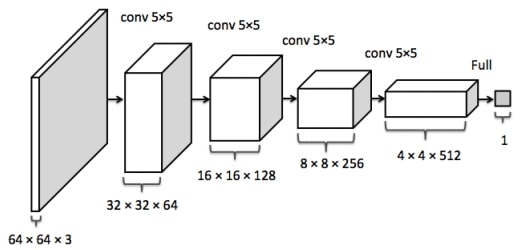
- All but the first and final Conv2D layers have Batch Normalization, since directly applying batchnorm to all layers could result in sample oscillation and model instability;
- The first four Conv2D layers use the **Leaky-Relu activation** with a slope of 0.2.
- Lastly, instead of a fully connected layer, the  output layer has a convolution layer with a **Sigmoid activation** function.


In [61]:
def make_discriminator():

    model=Sequential()

    # Block 1: input is 64 x 64 x (3)
    model.add(Input(shape=(64, 64, 3), name='input_layer'))
    model.add(Conv2D(64, kernel_size=4, strides= 2, padding='same', kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02), use_bias=False, name='conv_1'))
    model.add(LeakyReLU(0.2, name='leaky_relu_1'))

    # Block 2: input is 32 x 32 x (64)
    model.add(Conv2D(64 * 2, kernel_size=4, strides= 2, padding='same', kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02), use_bias=False, name='conv_2'))
    model.add(BatchNormalization(momentum=0.1,  epsilon=0.8, center=1.0, scale=0.02, name='bn_1'))
    model.add(LeakyReLU(0.2, name='leaky_relu_2'))

    # Block 3
    model.add(Conv2D(64 * 4, 4, 2, padding='same', kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02), use_bias=False, name='conv_3'))
    model.add(BatchNormalization(momentum=0.1,  epsilon=0.8, center=1.0, scale=0.02, name='bn_2'))
    model.add(LeakyReLU(0.2, name='leaky_relu_3'))


    #Block 4
    model.add(Conv2D(64 * 8, 4, 2, padding='same', kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02), use_bias=False, name='conv_4'))
    model.add(BatchNormalization(momentum=0.1,  epsilon=0.8, center=1.0, scale=0.02, name='bn_3'))
    model.add(LeakyReLU(0.2, name='leaky_relu_4'))


    #Block 5
    model.add(Conv2D(1, 4, 2,padding='same', kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02), use_bias=False,
                     activation='sigmoid', name='conv_5'))

    return model

# downsample an input image of size 64 x 64 x 3.
disc = make_discriminator()
disc.summary()

Model: "sequential_29"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv_1 (Conv2D)                 │ (None, 32, 32, 64)     │         3,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_relu_1 (LeakyReLU)        │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_2 (Conv2D)                 │ (None, 16, 16, 128)    │       131,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_1 (BatchNormalization)       │ (None, 16, 16, 128)    │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_relu_2 (LeakyReLU)        │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_3 (Conv2D)                 │ (None, 8, 8, 256)      │       524,288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_2 (BatchNormalization)       │ (None, 8, 8, 256)      │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_relu_3 (LeakyReLU)        │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_4 (Conv2D)                 │ (None, 4, 4, 512)      │     2,097,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_3 (BatchNormalization)       │ (None, 4, 4, 512)      │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_relu_4 (LeakyReLU)        │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_5 (Conv2D)                 │ (None, 2, 2, 1)        │         8,192 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,767,360 (10.56 MB)

 Trainable params: 2,765,568 (10.55 MB)

 Non-trainable params: 1,792 (7.00 KB)

## Loss Functions ##

- `learning rate = 0.0002`.
- beta coefficients $\beta_1 = 0.5$ and $\beta_2 = 0.999$, which are responsible for computing the running averages of the gradients during backpropagation.

In [ ]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True) # To be used to model the objectives of the two networks.

def generator_loss(Xhat):
    return cross_entropy(tf.ones_like(Xhat), Xhat)

def discriminator_loss(X, Xhat):
    real_loss = cross_entropy(tf.ones_like(X), X)
    fake_loss = cross_entropy(tf.zeros_like(Xhat), Xhat)
    total_loss = 0.5*(real_loss + fake_loss)
    return total_loss

learning_rate = 0.0002 # DCGAN's special feature

generator_optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate, beta_1=0.5, beta_2=0.999)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate, beta_1=0.5, beta_2=0.999)

## Train Step Functions ##

In [ ]:
@tf.function

def train_step(X):

    #random samples it was found if you increase the  stander deviation, you get better results
    z= tf.random.normal([BATCH_SIZE, 1, 1, latent_dim])
      
    # needed to compute the gradients for a list of variables.
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        
        # generated sample
        xhat = generator(z, training=True)
        
        # the output of the discriminator for real and fake data
        real_output = discriminator(X, training=True)
        fake_output = discriminator(xhat, training=True)

        # loss 
        gen_loss= generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)
      
    # Compute the gradients
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    # Ask the optimizer to apply the processed gradients
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss, fake_output, real_output, xhat

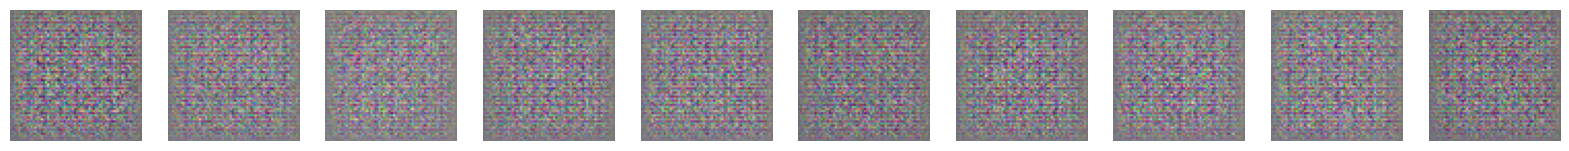

In [64]:
generator= make_generator()
BATCH_SIZE=128

latent_dim=100
noise = tf.random.normal([BATCH_SIZE, 1, 1, latent_dim])
Xhat=generator(noise,training=False)
plot_array(Xhat) # display noises as it hasn't been trained yet

## Training DCGANs ##

___Use for Display___

This part is to show the whole training process with loss values showing each percentage, so there is only one epoch for displaying the values. The real training part is below with 50 epochs.

In [ ]:
# Display
epochs = 1

discriminator = make_discriminator()
generator = make_generator()

save_dir = '/kaggle/working/generated_images'
os.makedirs(save_dir, exist_ok=True)

for epoch in range(epochs):
    start = time.time()
    for X in tqdm(normalized_ds, desc=f"epoch {epoch+1}", total=len(normalized_ds)):
        train_step(X)  
        gen_loss, disc_loss, fake_output, real_output, generated_images = train_step(X)
        
        print(f"Epoch {epoch + 1}, Step Losses:")
        print(f"  g_loss: {gen_loss.numpy():.4f} - d_loss: {disc_loss.numpy():.4f}")
    
    noise = tf.random.normal([BATCH_SIZE, 1, 1, latent_dim])
    Xhat = generator(noise, training=False)
    
    X = [x for x in normalized_ds]  
    print("original images")
    plot_array(X[0])
    print("generated images")
    plot_array(Xhat) # the generated image for display won't be saved
    print('Time for epoch {} is {} sec'.format(epoch + 1, time.time() - start))

___Real Training Part___

In [ ]:
# Real Training
epochs = 50

discriminator = make_discriminator()
generator = make_generator()

for epoch in range(epochs):
    start = time.time()
    for X in tqdm(normalized_ds, desc=f"epoch {epoch+1}", total=len(normalized_ds)):
        train_step(X)  
        gen_loss, disc_loss, fake_output, real_output, generated_images = train_step(X)

    # Print loss values
    print(f"Epoch {epoch + 1}, Losses:")
    print(f"  g_loss: {gen_loss.numpy():.4f} - d_loss: {disc_loss.numpy():.4f}")
    
    noise = tf.random.normal([BATCH_SIZE, 1, 1, latent_dim])
    Xhat = generator(noise, training=False)
    
    X = [x for x in normalized_ds]  
    print("original images")
    plot_array(X[0])
    print("generated images")
    plot_array(Xhat,save_to="/kaggle/working/generated_img_%03d.png" % (epoch+1),)
    print('Time for epoch {} is {} sec'.format(epoch + 1, time.time() - start))